###Mount drive to import datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 44.7 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
     |████████████████████████████████| 596 kB 49.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import pandas as pd
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Activation
from keras.layers import GlobalMaxPool1D
from keras.layers import Dropout, Conv1D, GlobalMaxPooling1D
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('punkt')
from transformers import LongformerTokenizerFast, LongformerForSequenceClassification, Trainer, TrainingArguments, LongformerConfig, TFLongformerModel, TFLongformerForSequenceClassification
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import os


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


###Functions

In [ ]:
def quickHistogram(labels, classes = ["other", "tech"]): 
  counts = []

  for i in range(len(classes)):
    count = 0
    for j in labels:
      if j == i:
        count += 1
    counts.append(count)

  plt.bar(classes, counts)
  plt.show()

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
from itertools import chain

def compareContent (base, new):

  #flatten list of lists
  base = chain.from_iterable(base)
  new = chain.from_iterable(new)

  #eliminate repeated words from counting
  baseSet = set(base)
  newSet = set(new)

  jointSet = baseSet.intersection(newSet)
  similarity = (len(jointSet)/len(baseSet))*100
  print ("{:.2f}".format(similarity) + '%' )


In [ ]:
import string

def clean_text(text): 
  if pd.isna(text) == False:
    delete_dict = {sp_character: ' ' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower().split(' ')

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Datasets

In [ ]:
dataMCTI = pd.read_excel("Datasets/oportunidades_classificacao_4.xlsx", sheet_name='Oportunidades')

# dataPPF = pd.read_excel("/content/drive/MyDrive/Mestrado/Datasets/db_PPF_validacao_para UNB_ FINAL.xlsx", sheet_name='Oportunidades')

In [ ]:
print("MCTI Dataset has " + str(dataMCTI.shape[0]) + " examples with " + str(dataMCTI.shape[1]) + " columns of information")

# print("PPF Dataset has " + str(dataPPF.shape[0]) + " examples with " + str(dataPPF.shape[1]) + " columns of information")

MCTI Dataset has 357 examples with 11 columns of information


In [ ]:
# dataPPF_new = dataPPF.copy()
# dataPPF_new = dataPPF_new.drop(columns=['html','houve mudança na classificação?'])

#TODO: IDENTIFY AND REMOVE NULL DATA IN OPO_TEXTO
#dataPPF_new.replace("", float("NaN"), inplace=True)
#dataPPF_new.dropna(subset = ['opo_texto'], inplace=True

In [ ]:
# concated = pd.concat([dataMCTI, dataPPF_new])

In [ ]:
newdata = dataMCTI.copy()
newdata = newdata[(newdata['clas'] == 'Y') | (newdata['clas'] == 'N')]
sentencesMCTI = newdata['opo_texto']
labels = newdata['clas']
labelsMCTI = np.where(labels == "Y", 1, 0)

In [ ]:
sentencesMCTIList = newdata['opo_texto'].apply(clean_text)
sentencesMCTIList = sentencesMCTIList.tolist()

## PPF data (unused)

In [ ]:
newdata = dataPPF.copy()
newdata = newdata[(newdata['clas'] == 'Y') | (newdata['clas'] == 'y') | (newdata['clas'] == 'N')]
sentencesPPF = newdata['opo_texto']
labels = newdata['clas']
labelsPPF = np.where(((labels == "Y") | (labels == "y")), 1, 0)

In [ ]:
sentencesPPFList = newdata['opo_texto'].apply(clean_text)
sentencesPPFList = sentencesPPFList.tolist()

In [ ]:
newdata = dataMCTI.copy()
newdata = newdata[(newdata['clas'] != 'Y') & (newdata['clas'] != 'N')]
complSentencesMCTI = newdata['opo_texto']

newdata = dataPPF.copy()
newdata = newdata[(newdata['clas'] != 'Y') & (newdata['clas'] != 'y') & (newdata['clas'] != 'N')]
complSentencesPPF = newdata['opo_texto']

del newdata

In [ ]:
complSentencesMCTIList = complSentencesMCTI.apply(clean_text)
complSentencesMCTIList = complSentencesMCTIList.tolist()

complSentencesPPFList = complSentencesPPF.apply(clean_text)
complSentencesPPFList = complSentencesPPFList.tolist()

# Longformer

In [ ]:
model = TFLongformerModel.from_pretrained('allenai/longformer-base-4096',
                                                          gradient_checkpointing=False,
                                                          attention_window = 512)

tokenizer = LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096', max_length = 4096)

Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerModel: ['lm_head']
- This IS expected if you are initializing TFLongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFLongformerModel were initialized from the model checkpoint at allenai/longformer-base-4096.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFLongformerModel for predictions without further training.


In [ ]:
input_vector = pad_sequences(sentencesMCTIList, dtype=object, maxlen=4096, padding='pre', value="_")

In [ ]:
sentences = []
for vector in input_vector:
  sentence = ' '.join([w for w in vector])
  sentences.append(sentence)

In [ ]:
encodings = []
for sentence in sentences:
  encoding = tokenizer(sentence, return_tensors="tf",  padding = 'max_length', truncation=True)
  encodings.append(encoding)

In [ ]:
model_outputs = []
for encoding in encodings:
  input_ids = encoding["input_ids"]
  output_without_mask = model(input_ids)[0]
  model_outputs.append(output_without_mask.numpy())

model_outputs = np.array(model_outputs)
print(model_outputs.shape)

(260, 1, 4096, 768)


In [ ]:
np.save("longformer_model.npy", model_outputs)

In [ ]:
model_outputs = np.load("longformer_model.npy")

In [ ]:
model_outputs = np.load("/content/drive/MyDrive/longformer_model.npy")

#Training the network#

In [ ]:
# create training testing data

#MCTI
x_trainMCTI, x_testMCTI, y_trainMCTI, y_testMCTI = train_test_split(model_outputs, labelsMCTI, test_size=0.20, random_state=20)

###NN###

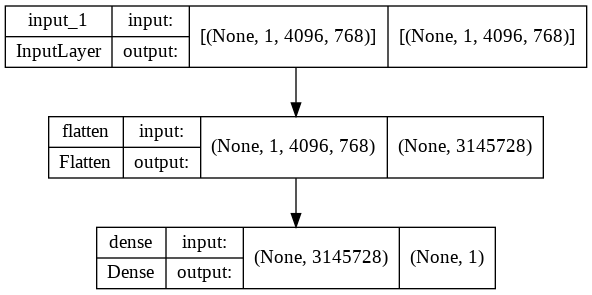

In [ ]:
mcti_NN_Model = Sequential()
mcti_NN_Model.add(Input(shape=np.shape(model_outputs[0])))
mcti_NN_Model.add(Flatten())
mcti_NN_Model.add(Dense(1, activation='sigmoid'))

keras.utils.plot_model(mcti_NN_Model, show_shapes=True)

In [ ]:
# add checkpoint to save the network and stop if training doesn't improve MCTI
filepath = "best weights mcti ppf NN.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
callbacks_list = [checkpoint, earlystop]

mcti_NN_Model.compile(optimizer='adam', loss='binary_crossentropy', 
                      metrics=['accuracy', f1_m, precision_m, recall_m])

# fiting  the model
history_NN_MCTI = mcti_NN_Model.fit(x_trainMCTI, y_trainMCTI, epochs=100, 
                                    callbacks=callbacks_list, verbose=True, 
                                    validation_data=(x_testMCTI, y_testMCTI), 
                                    batch_size=16)

# evaluate the model
loss, accuracy, f1_score, precision, recall = mcti_NN_Model.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('f1_score: %f' % (f1_score*100))
print('precision: %f' % (precision*100))
print('recall: %f' % (recall*100))

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 107.8297 - accuracy: 0.5240 - f1_m: 0.4466 - precision_m: 0.4968 - recall_m: 0.5760
Epoch 1: val_accuracy improved from -inf to 0.38462, saving model to best weights mcti ppf NN.h5
13/13 [==============================] - 3s 154ms/step - loss: 107.8297 - accuracy: 0.5240 - f1_m: 0.4466 - precision_m: 0.4968 - recall_m: 0.5760 - val_loss: 82.8328 - val_accuracy: 0.3846 - val_f1_m: 0.0839 - val_precision_m: 0.5000 - val_recall_m: 0.0458
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 45.8894 - accuracy: 0.5769 - f1_m: 0.5508 - precision_m: 0.6775 - recall_m: 0.6598
Epoch 2: val_accuracy did not improve from 0.38462
13/13 [==============================] - 1s 79ms/step - loss: 45.8894 - accuracy: 0.5769 - f1_m: 0.5508 - precision_m: 0.6775 - recall_m: 0.6598 - val_loss: 65.0223 - val_accuracy: 0.3846 - val_f1_m: 0.0839 - val_precision_m: 0.5000 - val_recall_m: 0.0458
Epoch 3/100
13/13 [==============

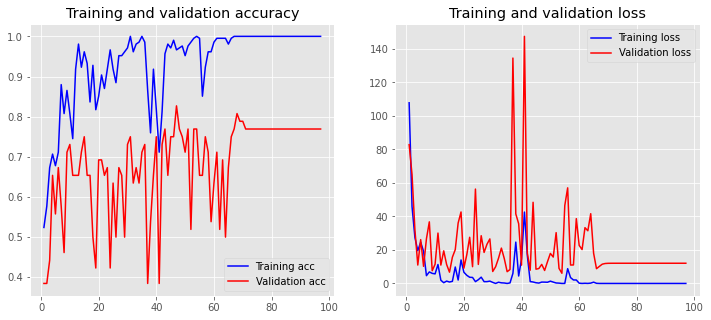

In [ ]:
plot_history(history_NN_MCTI)

In [ ]:
reconstructed_model = keras.models.load_model("best weights mcti ppf NN10.h5", custom_objects={'f1_m':f1_m, "precision_m":precision_m, "recall_m":recall_m})
# evaluate the model
loss, accuracy, f1_score, precision, recall = reconstructed_model.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('f1_score: %f' % (f1_score*100))
print('precision: %f' % (precision*100))
print('recall: %f' % (recall*100))


Accuracy: 82.692307
f1_score: 87.537986
precision: 79.499996
recall: 97.727275


###DNN###

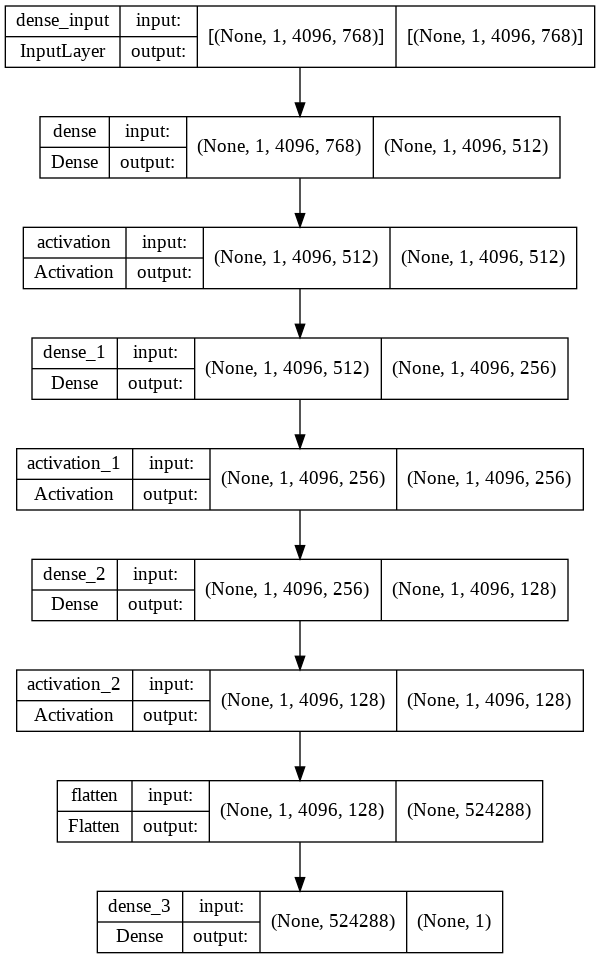

In [ ]:
mcti_DNN_Model = Sequential()
mcti_DNN_Model.add(Dense(512, input_shape=np.shape(model_outputs[0])))
mcti_DNN_Model.add(Activation('relu'))
mcti_DNN_Model.add(Dense(256))
mcti_DNN_Model.add(Activation('relu'))
mcti_DNN_Model.add(Dense(128))
mcti_DNN_Model.add(Activation('relu'))
mcti_DNN_Model.add(Flatten())
mcti_DNN_Model.add(Dense(1, activation='sigmoid'))

keras.utils.plot_model(mcti_DNN_Model, show_shapes=True)

In [ ]:
# add checkpoint to save the network and stop if training doesn't improve MCTI
filepath = "best weights mcti ppf DNN.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
callbacks_list = [checkpoint, earlystop]

mcti_DNN_Model.compile(optimizer='adam', loss='binary_crossentropy', 
                      metrics=['accuracy', f1_m, precision_m, recall_m])

# fiting  the model
history_DNN_MCTI = mcti_DNN_Model.fit(x_trainMCTI, y_trainMCTI, epochs=100, 
                                    callbacks=callbacks_list, verbose=True, 
                                    validation_data=(x_testMCTI, y_testMCTI), 
                                    batch_size=16)

# evaluate the model
loss, accuracy, f1_score, precision, recall = mcti_DNN_Model.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('f1_score: %f' % (f1_score*100))
print('precision: %f' % (precision*100))
print('recall: %f' % (recall*100))

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 5.5540 - accuracy: 0.5144 - f1_m: 0.4062 - precision_m: 0.3986 - recall_m: 0.5264
Epoch 1: val_accuracy improved from -inf to 0.65385, saving model to best weights mcti ppf DNN.h5
13/13 [==============================] - 3s 185ms/step - loss: 5.5540 - accuracy: 0.5144 - f1_m: 0.4062 - precision_m: 0.3986 - recall_m: 0.5264 - val_loss: 1.3171 - val_accuracy: 0.6538 - val_f1_m: 0.7656 - val_precision_m: 0.6250 - val_recall_m: 1.0000
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.8361 - accuracy: 0.6298 - f1_m: 0.5948 - precision_m: 0.6394 - recall_m: 0.6956
Epoch 2: val_accuracy did not improve from 0.65385
13/13 [==============================] - 1s 110ms/step - loss: 0.8361 - accuracy: 0.6298 - f1_m: 0.5948 - precision_m: 0.6394 - recall_m: 0.6956 - val_loss: 1.0682 - val_accuracy: 0.6538 - val_f1_m: 0.7656 - val_precision_m: 0.6250 - val_recall_m: 1.0000
Epoch 3/100
13/13 [====================

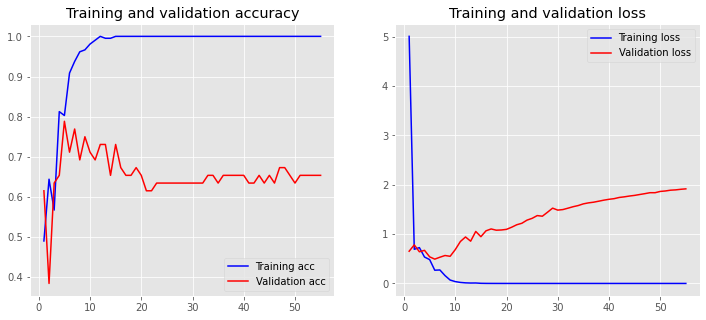

In [ ]:
plot_history(history_DNN_MCTI)

In [ ]:
reconstructed_model = keras.models.load_model("best weights mcti ppf DNN1.h5", custom_objects={'f1_m':f1_m, "precision_m":precision_m, "recall_m":recall_m})
# evaluate the model
loss, accuracy, f1_score, precision, recall = reconstructed_model.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('f1_score: %f' % (f1_score*100))
print('precision: %f' % (precision*100))
print('recall: %f' % (recall*100))


Accuracy: 84.615386
f1_score: 87.762231
precision: 84.740257
recall: 91.287881


###CNN###

In [ ]:
model_outputs.shape

(260, 1, 4096, 768)

In [ ]:
model_outputs = np.reshape(model_outputs, (260,4096,768))
model_outputs.shape

(260, 4096, 768)

In [ ]:
x_trainMCTI, x_testMCTI, y_trainMCTI, y_testMCTI = train_test_split(model_outputs, labelsMCTI, test_size=0.20, random_state=20)

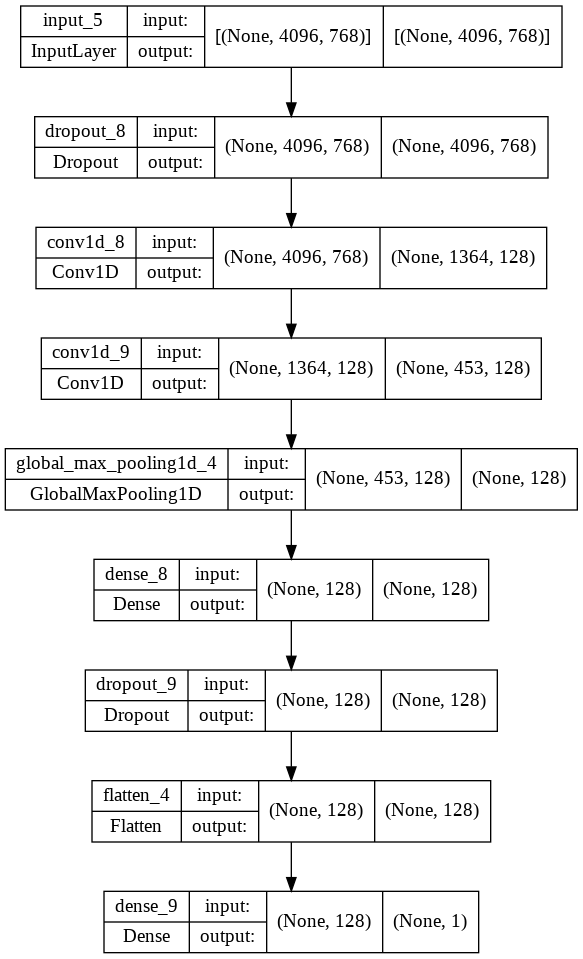

In [ ]:
mcti_CNN_Model = Sequential()
mcti_CNN_Model.add(Input(shape=np.shape(model_outputs[0])))
mcti_CNN_Model.add(Dropout(0.5))

# Conv1D + global max pooling
mcti_CNN_Model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
mcti_CNN_Model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
mcti_CNN_Model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
mcti_CNN_Model.add(Dense(128, activation="relu"))
mcti_CNN_Model.add(Dropout(0.5))

mcti_CNN_Model.add(Flatten())
mcti_CNN_Model.add(Dense(1, activation='sigmoid'))

keras.utils.plot_model(mcti_CNN_Model, show_shapes=True)

In [ ]:
# add checkpoint to save the network and stop if training doesn't improve MCTI
filepath = "best weights mcti ppf CNN.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
callbacks_list = [checkpoint, earlystop]

mcti_CNN_Model.compile(optimizer='adam', loss='binary_crossentropy', 
                       metrics=['accuracy', f1_m, precision_m, recall_m])

# fiting  the model
history_CNN_MCTI = mcti_CNN_Model.fit(x_trainMCTI, y_trainMCTI, epochs=100, 
                                    callbacks=callbacks_list, verbose=True, 
                                    validation_data=(x_testMCTI, y_testMCTI), 
                                    batch_size=16)

# evaluate the model
loss, accuracy, f1_score, precision, recall = mcti_CNN_Model.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('f1_score: %f' % (f1_score*100))
print('precision: %f' % (precision*100))
print('recall: %f' % (recall*100))

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 0.9130 - accuracy: 0.5625 - f1_m: 0.5872 - precision_m: 0.6613 - recall_m: 0.6069
Epoch 1: val_accuracy improved from -inf to 0.36538, saving model to best weights mcti ppf CNN.h5
13/13 [==============================] - 4s 204ms/step - loss: 0.9130 - accuracy: 0.5625 - f1_m: 0.5872 - precision_m: 0.6613 - recall_m: 0.6069 - val_loss: 0.7186 - val_accuracy: 0.3654 - val_f1_m: 0.0455 - val_precision_m: 0.2500 - val_recall_m: 0.0250
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.7614 - accuracy: 0.5577 - f1_m: 0.5947 - precision_m: 0.6401 - recall_m: 0.6197
Epoch 2: val_accuracy improved from 0.36538 to 0.65385, saving model to best weights mcti ppf CNN.h5
13/13 [==============================] - 1s 97ms/step - loss: 0.7614 - accuracy: 0.5577 - f1_m: 0.5947 - precision_m: 0.6401 - recall_m: 0.6197 - val_loss: 0.6660 - val_accuracy: 0.6538 - val_f1_m: 0.7656 - val_precision_m: 0.6250 - val_recall_

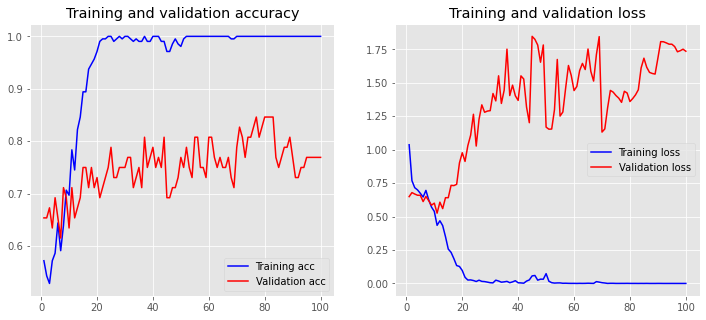

In [ ]:
plot_history(history_CNN_MCTI)

In [ ]:
reconstructed_model = keras.models.load_model("best weights mcti ppf CNN7.h5", custom_objects={'f1_m':f1_m, "precision_m":precision_m, "recall_m":recall_m})
# evaluate the model
loss, accuracy, f1_score, precision, recall = reconstructed_model.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('f1_score: %f' % (f1_score*100))
print('precision: %f' % (precision*100))
print('recall: %f' % (recall*100))

Accuracy: 84.615386
f1_score: 87.762231
precision: 84.740257
recall: 91.287881


###LSTM###

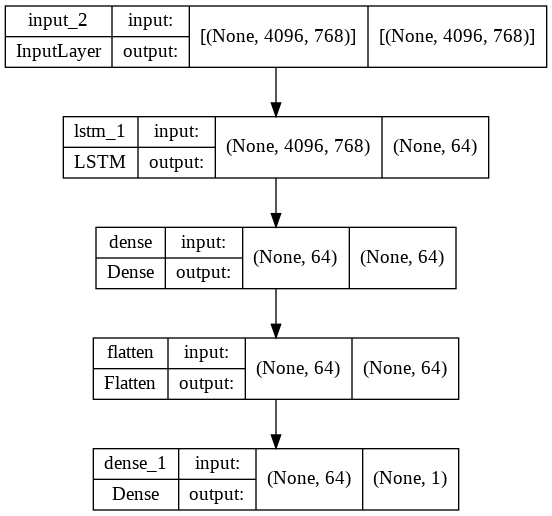

In [ ]:
mcti_LSTM_Model = Sequential()
mcti_LSTM_Model.add(Input(shape=np.shape(model_outputs[0])))
mcti_LSTM_Model.add(LSTM(64))
mcti_LSTM_Model.add(Dense(64, activation='relu'))
mcti_LSTM_Model.add(Flatten())
mcti_LSTM_Model.add(Dense(1, activation='sigmoid'))

keras.utils.plot_model(mcti_LSTM_Model, show_shapes=True)

In [ ]:
# add checkpoint to save the network and stop if training doesn't improve MCTI
filepath = "best weights mcti ppf LSTM.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
callbacks_list = [checkpoint, earlystop]

mcti_LSTM_Model.compile(optimizer='adam', loss='binary_crossentropy', 
                        metrics=['accuracy', f1_m, precision_m, recall_m])

# fiting  the model
history_LSTM_MCTI = mcti_LSTM_Model.fit(x_trainMCTI, y_trainMCTI, epochs=100, 
                                    callbacks=callbacks_list, verbose=True, 
                                    validation_data=(x_testMCTI, y_testMCTI), 
                                    batch_size=16)

# evaluate the model
loss, accuracy, f1_score, precision, recall = mcti_LSTM_Model.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('f1_score: %f' % (f1_score*100))
print('precision: %f' % (precision*100))
print('recall: %f' % (recall*100))

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 0.7011 - accuracy: 0.5529 - f1_m: 0.6315 - precision_m: 0.5334 - recall_m: 0.8615
Epoch 1: val_accuracy improved from -inf to 0.57692, saving model to best weights mcti ppf LSTM.h5
13/13 [==============================] - 7s 330ms/step - loss: 0.7011 - accuracy: 0.5529 - f1_m: 0.6315 - precision_m: 0.5334 - recall_m: 0.8615 - val_loss: 0.6869 - val_accuracy: 0.5769 - val_f1_m: 0.5431 - val_precision_m: 0.5322 - val_recall_m: 0.5583
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.6568 - accuracy: 0.6635 - f1_m: 0.5822 - precision_m: 0.8945 - recall_m: 0.5042
Epoch 2: val_accuracy improved from 0.57692 to 0.65385, saving model to best weights mcti ppf LSTM.h5
13/13 [==============================] - 3s 226ms/step - loss: 0.6568 - accuracy: 0.6635 - f1_m: 0.5822 - precision_m: 0.8945 - recall_m: 0.5042 - val_loss: 0.6475 - val_accuracy: 0.6538 - val_f1_m: 0.7610 - val_precision_m: 0.6292 - val_reca

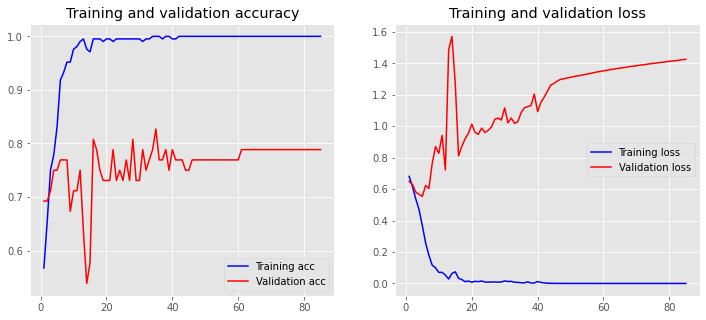

In [ ]:
plot_history(history_LSTM_MCTI)

In [ ]:
reconstructed_model = keras.models.load_model("best weights mcti ppf LSTM7.h5", custom_objects={'f1_m':f1_m, "precision_m":precision_m, "recall_m":recall_m})
# evaluate the model
loss, accuracy, f1_score, precision, recall = reconstructed_model.evaluate(x_testMCTI, 
                                                                     y_testMCTI, 
                                                                     verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('f1_score: %f' % (f1_score*100))
print('precision: %f' % (precision*100))
print('recall: %f' % (recall*100))

Accuracy: 82.692307
f1_score: 88.014311
precision: 85.714287
recall: 90.909088
